<a href="https://colab.research.google.com/github/up2113232/up2113232_coursework/blob/dev/Q2_folder/Q2_NN_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Gaming Mental Health Prediction with Neural Networks
## Predicting GAD_T, SWL_T, and SPIN_T Scores from Gaming Behavior

This notebook demonstrates how to build a neural network to predict mental health scores
(GAD_T = Anxiety, SWL_T = Life Satisfaction, SPIN_T = Social Phobia) based on gaming habits.

**Dataset:** Online Gaming Anxiety Data from Kaggle
**Target Variables:** GAD_T, SWL_T, SPIN_T


First things first we have to import all of our important libraries that will be used.

In [26]:
# Import necessary libraries
import sys # Used for system-specific parameters and functions, like modifying the Python path
import os  # Provides a way of using operating system dependent functionality, like file paths

# Add parent directory to path to import our functions
# This line ensures Python can find our custom 'functions.py' file, which likely contains
# helper functions for data cleaning, encoding, splitting, and scaling.
sys.path.append('..')

# Core data manipulation and visualisation libraries
# pandas is crucial for handling data in tables (DataFrames)
import pandas as pd
# numpy is used for numerical operations, especially with arrays
import numpy as np
# matplotlib is a foundational library for creating static, interactive, and animated visualizations
import matplotlib.pyplot as plt
# seaborn is built on matplotlib and provides a high-level interface for drawing attractive statistical graphics
import seaborn as sns

# Machine learning and preprocessing libraries from scikit-learn
# train_test_split: for dividing data into training and testing sets
# cross_val_score: for evaluating model performance using cross-validation
# GridSearchCV: for hyperparameter tuning (finding the best parameters for a model)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# StandardScaler: for standardizing features by removing the mean and scaling to unit variance
# LabelEncoder: for converting categorical labels into numerical format
# MinMaxScaler: for scaling features to a given range, usually between zero and one
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
# mean_squared_error, mean_absolute_error, r2_score: metrics to evaluate regression model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# MLPRegressor: Multi-layer Perceptron regressor, a type of neural network for regression tasks
from sklearn.neural_network import MLPRegressor
# MultiOutputRegressor: a strategy for fitting a single regressor on multiple targets
from sklearn.multioutput import MultiOutputRegressor

# System and warnings
# This line is used to ignore warning messages that might clutter the output
import warnings
warnings.filterwarnings('ignore')

Then we will load the functions we will use in this notebook from our functions file

In [27]:
# From our custom 'functions.py' file, we import specific helper functions.
# These functions encapsulate common data processing steps, making our main notebook cleaner and more organized.
# - clean_data: likely handles initial data cleaning (e.g., duplicates, basic missing value handling).
# - encode_features: converts non-numerical (categorical) data into numerical format that machine learning models can understand.
# - split_data: divides the dataset into training and testing sets.
# - scale_features: normalizes or standardizes numerical features.
from functions import clean_data, encode_features, split_data, scale_features

Now we have to load our data as a pandas data frame so we can manipulate it easier.

In [28]:
# Load the dataset from a CSV file into a pandas DataFrame.
# The 'encoding' parameter is specified to handle potential character encoding issues in the file.
# We use a try-except block to gracefully handle the case where the file might not be found.
try:
  df = pd.read_csv('gaming_anxiety_data.csv', encoding='ISO-8859-1')

except FileNotFoundError:
  print(" File not found! Please upload your dataset first.")

In [29]:
# Define the columns that will be used as input features for our Neural Network.
# These are the independent variables (X) that the network will use to make predictions.
feature_columns = ['GADE', 'Game', 'Hours', 'earnings', 'whyplay',
                   'streams', 'Narcissism', 'Gender',
                   'Age', 'Work', 'Playstyle']

# Define the target columns. These are the dependent variables (y) we want to predict.
# Our network will try to learn the relationship between 'feature_columns' and 'target_columns'.
target_columns = ['GAD_T', 'SWL_T', 'SPIN_T']

# Create a new DataFrame 'df' containing only the selected feature and target columns.
# .copy() is used to ensure we are working with a separate copy of the data,
# preventing unintended modifications to the original DataFrame loaded earlier.
df = df[feature_columns + target_columns].copy()

In [30]:
# Call the 'clean_data' function (imported from functions.py) to handle initial data cleaning steps.
# This function typically removes duplicate rows and might display information about missing values.
# The cleaned data is stored in a new DataFrame called 'df_cleaned_initial'.
print("Cleaning dataset...")
df_cleaned_initial = clean_data(df)

Cleaning dataset...
Missing values per column:
GADE          649
Game            0
Hours          30
earnings        0
whyplay         0
streams       100
Narcissism     23
Gender          0
Age             0
Work           38
Playstyle       0
GAD_T           0
SWL_T           0
SPIN_T        650
dtype: int64
Removed 0 rows with missing values
Removed 51 duplicate rows


In [31]:
# We will encode the string values (categorical features) into corresponding numbers using 'encode_features'.
# This is necessary because Neural Networks typically require numerical inputs.
df_encoded = encode_features(df_cleaned_initial)

# We will then clean up any remaining missing values by dropping rows that contain NaN (Not a Number).
# This ensures that our final dataset 'df_clean' is entirely numerical and free of missing data.
df_clean = df_encoded.dropna()

# Print a summary of missing values to confirm the cleaning process was successful.
print(f"\n Original Missing values: {df.isnull().sum().sum()}")
print(f" Missing values after cleaning and encoding: {df_clean.isnull().sum().sum()}")
# If there are still missing values, this block will print which columns contain them.
if df_clean.isnull().sum().sum() > 0:
    print("Columns with missing values in df_clean:")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])


 Original Missing values: 1490
 Missing values after cleaning and encoding: 0


Now we are going to split and scale our data, just like in Q1 as Neural networks require the same format of data and we will use a 80/20 train/test split for our NN

In [32]:
# Separate the features (X) from the target variables (y).
# X contains the input data, and y contains the values we want to predict.
X = df_clean[feature_columns]
y = df_clean[target_columns]

# Define the proportion of data to be used for testing (20%) and a random state for reproducibility.
test_size = 0.2
random_state = 42

# Split the data into training and testing sets using the split_data function.
# X_train, y_train are used to train the model.
# X_test, y_test are used to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size, random_state=random_state)

# Initialize StandardScaler to normalize the feature data.
# Scaling is important for neural networks as it helps with faster convergence and better performance.
scaler = StandardScaler()
# Fit the scaler on the training features and then transform both training and test features.
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize another StandardScaler for the target variables.
# It's good practice to scale target variables as well when using regression models.
target_scaler = StandardScaler()
# Fit and transform the training target variables.
y_train_scaled = target_scaler.fit_transform(y_train)
# Transform the test target variables (using the scaler fitted on training targets).
y_test_scaled = target_scaler.transform(y_test)

In [76]:
# Initialize a Multi-layer Perceptron (MLP) Regressor, which is a type of neural network.
model = MLPRegressor(
    #Defines the architecture of the hidden layers. (128, 64, 32, 16) means 4
    # hidden layers with (128, 64, 32, 16) neurons respectively.
    hidden_layer_sizes=(128, 64, 32, 16),
    #The activation function for the hidden layers. 'relu' (Rectified Linear Unit) is a common choice.
    activation='tanh',
    #The algorithm for weight optimization. 'adam' is an efficient stochastic optimizer.
    solver='adam',
    #The size of minibatches for stochastic optimizers. 32 is a common batch size.
    batch_size=16,
    # learning_rate: How the learning rate is adjusted over time. 'adaptive' decreases it when validation score stops improving.
    alpha=0.001,
    learning_rate='adaptive',
    # learning_rate_init: The initial learning rate.
    learning_rate_init=0.01,
    # max_iter: The maximum number of epochs (iterations over the entire training data).
    max_iter=500,
    # random_state: Ensures reproducibility of the results.
    random_state=42,
    # verbose: If True, prints progress messages to stdout.
    verbose=True,
    # early_stopping: Whether to use early stopping to terminate training when validation score is not improving.
    early_stopping=True,
    # validation_fraction: The proportion of training data to set aside as validation set for early stopping.
    validation_fraction=0.2,
    # n_iter_no_change: Maximum number of epochs to not meet `tol` improvement before early stopping.
    n_iter_no_change=50
)

### Model Training

Now we will train our neural network using the scaled training data (`X_train_scaled`, `y_train_scaled`). The model will learn patterns from this data to make predictions.

In [93]:
model.fit(X_train_scaled, y_train_scaled)
print("Model training complete.")

Iteration 1, loss = 0.43766001
Validation score: 0.152234
Iteration 2, loss = 0.42298689
Validation score: 0.198400
Iteration 3, loss = 0.43376537
Validation score: 0.199451
Iteration 4, loss = 0.42710954
Validation score: 0.147273
Iteration 5, loss = 0.43621392
Validation score: 0.107828
Iteration 6, loss = 0.44698938
Validation score: 0.212746
Iteration 7, loss = 0.43724185
Validation score: 0.214871
Iteration 8, loss = 0.43407660
Validation score: 0.217007
Iteration 9, loss = 0.44179792
Validation score: 0.221236
Iteration 10, loss = 0.45368645
Validation score: 0.151230
Iteration 11, loss = 0.45359772
Validation score: 0.223651
Iteration 12, loss = 0.45437000
Validation score: 0.225437
Iteration 13, loss = 0.45715562
Validation score: 0.218247
Iteration 14, loss = 0.45202214
Validation score: 0.217029
Iteration 15, loss = 0.44997102
Validation score: 0.221976
Iteration 16, loss = 0.44775250
Validation score: 0.184800
Iteration 17, loss = 0.44920956
Validation score: 0.204651
Iterat

In [94]:
y_pred_scaled = model.predict(X_test_scaled)
print("Predictions on scaled test data complete.")

Predictions on scaled test data complete.


In [95]:
y_pred = target_scaler.inverse_transform(y_pred_scaled)
print("Inverse transformation of predictions complete.")

Inverse transformation of predictions complete.


In [96]:
print("\n--- Model Evaluation ---")

results = {}
# Evaluate the model for each target variable
for i, target_col in enumerate(target_columns):
    print(f"\nMetrics for {target_col}:")

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"  Mean Squared Error (MSE): {mse:.4f}")

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")

    # Calculate R-squared score
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"  R-squared (R2): {r2:.4f}")




--- Model Evaluation ---

Metrics for GAD_T:
  Mean Squared Error (MSE): 13.0714
  Mean Absolute Error (MAE): 2.7308
  R-squared (R2): 0.3898

Metrics for SWL_T:
  Mean Squared Error (MSE): 42.6335
  Mean Absolute Error (MAE): 5.4088
  R-squared (R2): 0.1526

Metrics for SPIN_T:
  Mean Squared Error (MSE): 154.2018
  Mean Absolute Error (MAE): 9.7896
  R-squared (R2): 0.1188



--- Visualizing Predictions ---


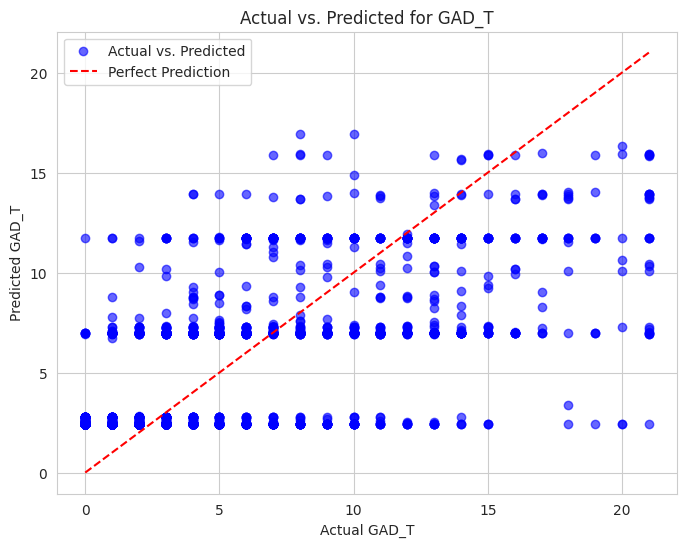

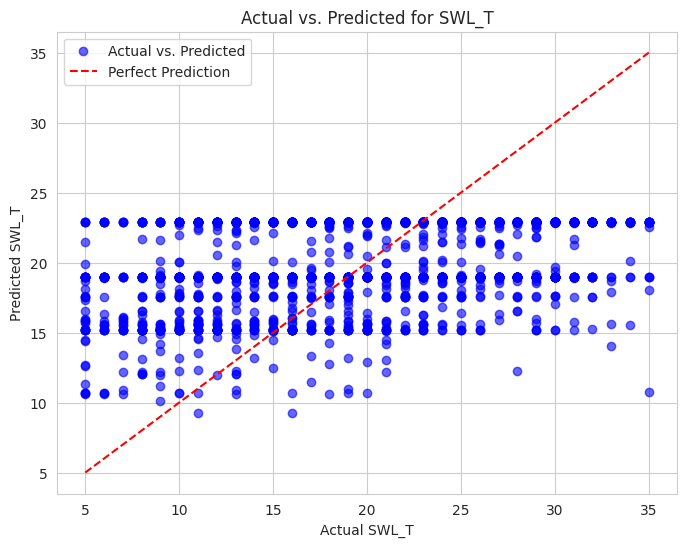

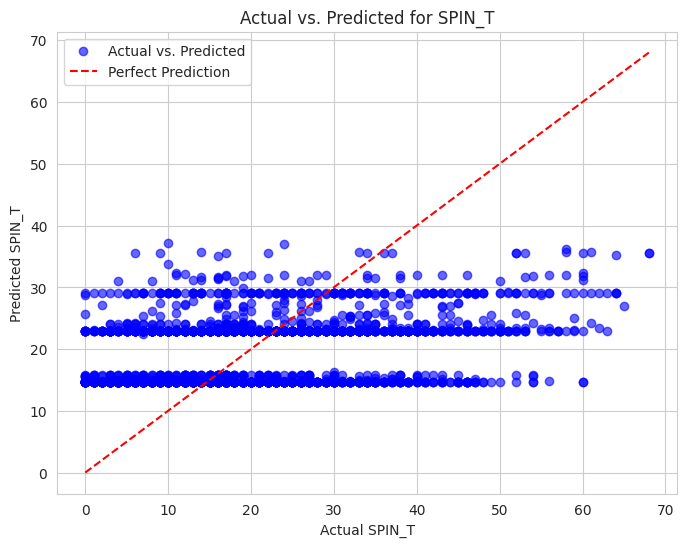

In [97]:
print("\n--- Visualizing Predictions ---")

# Create scatter plots for each target variable
for i, target_col in enumerate(target_columns):
    plt.figure(figsize=(8, 6))

    # Scatter plot of actual vs. predicted values
    plt.scatter(y_test.iloc[:, i], y_pred[:, i], alpha=0.6, color='blue', label='Actual vs. Predicted')

    # Add a line for perfect predictions (actual = predicted)
    max_val = max(y_test.iloc[:, i].max(), y_pred[:, i].max())
    min_val = min(y_test.iloc[:, i].min(), y_pred[:, i].min())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')

    # Set title and labels
    plt.title(f'Actual vs. Predicted for {target_col}')
    plt.xlabel(f'Actual {target_col}')
    plt.ylabel(f'Predicted {target_col}')
    plt.legend()
    plt.grid(True)
    plt.show()